# Airplane Engine Detection
Detect Airplane Engine from FDM Data. Engine are identified using these columns:
1. `engcycle_x_hr`: If exist `engcycle_4_hr` column value, then airplane has 4 engine.
2. `ctrlcolumn_pos_capt`: If exist `ctrlcolumn_pos_capt` column value, then airplane engine is B747, otherwise it's A380.

### Import

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import math
import numpy as np
import pandas as pd
import seaborn as sns

### Define File

In [34]:
# base_path = '../dataset/database_local'
base_path = '../dataset/database'

In [35]:
# Input
flight_runway_file = f'{base_path}/04_flights_with_runway.csv'
landing_runway_file = f'{base_path}/04_landing_count_detail.csv'

# Output
output_file = f'{base_path}/05_flight_engine.csv'

### Read Data

#### 1. Read Flight Runway Data 

In [36]:
flight_runway = pd.read_csv(flight_runway_file)
flight_runway.head()

,fname,tail_id,dep_airport,dep_rwy,arr_airport,arr_rwy,fsize_mb,fullpath
0,686200104111724.csv,tail_686_1,MSP,22,FNT,18,50.99,/Volumes/My Passport/desy/tail_686_1/686200104...
1,686200104120602.csv,tail_686_1,FNT,18,DTW,09L,24.43,/Volumes/My Passport/desy/tail_686_1/686200104...
2,686200104120802.csv,tail_686_1,DTW,09L,LEX,22,40.53,/Volumes/My Passport/desy/tail_686_1/686200104...
3,686200104121013.csv,tail_686_1,LEX,22,DTW,09L,43.39,/Volumes/My Passport/desy/tail_686_1/686200104...
4,686200104121245.csv,tail_686_1,DTW,03L,BHM,24,61.52,/Volumes/My Passport/desy/tail_686_1/686200104...


#### 2. Read Landing Runway Count

In [37]:
landing_runway_count = pd.read_csv(landing_runway_file)
landing_runway_count.head()

,iata_code,runway_ident,flight_count,icao_code,type,name,latitude_rad,longitude_rad,elevation_ft,scheduled_service
0,MSP,MSP.30R,1847,KMSP,large_airport,Minneapolis-St Paul International/Wold-Chamber...,0.783339,-1.627027,841.0,yes
1,DTW,DTW.03L,713,KDTW,large_airport,Detroit Metropolitan Wayne County Airport,0.736745,-1.454791,645.0,yes
2,DTW,DTW.09L,628,KDTW,large_airport,Detroit Metropolitan Wayne County Airport,0.736745,-1.454791,645.0,yes
3,MEM,MEM.18L,542,KMEM,large_airport,Memphis International Airport,0.611605,-1.570390,341.0,yes
4,MEM,MEM.18R,347,KMEM,large_airport,Memphis International Airport,0.611605,-1.570390,341.0,yes


## Transform Data 

#### 1. Append Full Runway Id Column

In [38]:
arrival_runway_id = flight_runway['arr_airport'] + '.' + flight_runway['arr_rwy']
arrival_runway_id.head()

0     FNT.18
1    DTW.09L
2     LEX.22
3    DTW.09L
4     BHM.24
dtype: object

In [39]:
flight_runway['arr_rwy_id'] = arrival_runway_id
flight_runway.head()

,fname,tail_id,dep_airport,dep_rwy,arr_airport,arr_rwy,fsize_mb,fullpath,arr_rwy_id
0,686200104111724.csv,tail_686_1,MSP,22,FNT,18,50.99,/Volumes/My Passport/desy/tail_686_1/686200104...,FNT.18
1,686200104120602.csv,tail_686_1,FNT,18,DTW,09L,24.43,/Volumes/My Passport/desy/tail_686_1/686200104...,DTW.09L
2,686200104120802.csv,tail_686_1,DTW,09L,LEX,22,40.53,/Volumes/My Passport/desy/tail_686_1/686200104...,LEX.22
3,686200104121013.csv,tail_686_1,LEX,22,DTW,09L,43.39,/Volumes/My Passport/desy/tail_686_1/686200104...,DTW.09L
4,686200104121245.csv,tail_686_1,DTW,03L,BHM,24,61.52,/Volumes/My Passport/desy/tail_686_1/686200104...,BHM.24


#### 2. Select Flight with Selected Runway Id

In [40]:
# Choose flight's landing runway to detect airplane engine
# landing_runways = ['MSP.30R']
landing_runways = ['MSP.30R', 'DTW.09R']

In [41]:
selected_flight = flight_runway[flight_runway['arr_rwy_id'].isin(landing_runways)]
display(selected_flight.head())
selected_flight.shape

,fname,tail_id,dep_airport,dep_rwy,arr_airport,arr_rwy,fsize_mb,fullpath,arr_rwy_id
5,686200104121532.csv,tail_686_1,BHM,36,DTW,09R,68.39,/Volumes/My Passport/desy/tail_686_1/686200104...,DTW.09R
7,686200104130429.csv,tail_686_1,LEX,22,DTW,09R,42.63,/Volumes/My Passport/desy/tail_686_1/686200104...,DTW.09R
33,686200104160640.csv,tail_686_1,CVG,18C,MSP,30R,80.96,/Volumes/My Passport/desy/tail_686_1/686200104...,MSP.30R
35,686200104161057.csv,tail_686_1,MSN,18,MSP,30R,48.32,/Volumes/My Passport/desy/tail_686_1/686200104...,MSP.30R
37,686200104170613.csv,tail_686_1,GSO,32,MSP,30R,108.79,/Volumes/My Passport/desy/tail_686_1/686200104...,MSP.30R


(2095, 9)

#### 3. Create Helper Function to Detect Engine

../dataset/fdm/tail_686_1/686200104121532.csv
B747


,n11_rpm,n12_rpm,n13_rpm,n14_rpm,n21_rpm,n22_rpm,n23_rpm,n24_rpm,ctrlcolumn_pos_capt,ctrlcolumn_pos_fo,eng_1_hr,eng_2_hr,eng_3_hr,eng_4_hr
0,1.0,1.75,1.75,0.9375,0.0,0.0,0.0,0.0,2825.0,1904.0,8864.0,6369.0,6369.0,8528.0
64,1.0,1.75,1.75,0.9375,0.0,0.0,0.0,0.0,2825.0,1904.0,8864.0,6369.0,6369.0,8528.0
128,1.0,1.75,1.75,0.9375,0.0,0.0,0.0,0.0,2825.0,1904.0,8864.0,6369.0,6369.0,8528.0
192,1.0,1.75,1.75,0.9375,0.0,0.0,0.0,0.0,2825.0,1903.0,8864.0,6369.0,6369.0,8528.0
256,1.0,1.75,1.75,0.9375,0.0,0.0,0.0,0.0,2825.0,1903.0,8864.0,6369.0,6369.0,8528.0


<AxesSubplot:ylabel='ctrlcolumn_pos_capt'>

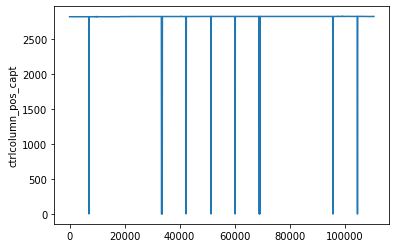

In [28]:
# For debugging function
fpath = selected_flight.sample(1).fullpath.iloc[0]
print(fpath)
fdm_df = pd.read_csv(fpath)

engine = None
if fdm_df['engcycle_4_hr'].sum() > 0:
    n_engine = 4
    if fdm_df['ctrlcolumn_pos_capt'].sum() > 0:
        engine = 'B747'
    else:
        engine = 'A380'
print(engine)
        
select_col = ['n11_rpm', 'n12_rpm', 'n13_rpm', 'n14_rpm', 'n21_rpm', 'n22_rpm', 'n23_rpm', \
              'n24_rpm', 'ctrlcolumn_pos_capt', 'ctrlcolumn_pos_fo', 'eng_1_hr', 'eng_2_hr',\
              'eng_3_hr', 'eng_4_hr']
test_df = fdm_df[select_col].dropna()
display(test_df.head())
sns.lineplot(data=test_df.ctrlcolumn_pos_capt)

#### Main Function

In [29]:
def identify_engine(filepath):
    sum_pos_fo_treshold = 0.3 * pow(10, 7)
    sum_pos_capt_treshold = 0.3 * pow(10, 7)
    
    fdm_df = pd.read_csv(filepath)
    engine = None
    if fdm_df['engcycle_4_hr'].sum() > 0:
        n_engine = 4
        if fdm_df['ctrlcolumn_pos_capt'].sum() > sum_pos_capt_treshold \
        and fdm_df['ctrlcolumn_pos_fo'].sum() > sum_pos_fo_treshold:
            engine = 'B747'
        else:
            engine = 'A380'
    print(f'{filepath}: {engine}')
    return engine

In [30]:
identify_engine(fpath)

../dataset/fdm/tail_686_1/686200104121532.csv: B747


'B747'

#### 4. Determine Engine

In [32]:
engines = flight_runway.sample(5).fullpath.map(identify_engine)
engines

../dataset/fdm/tail_687_1/686200104130652.csv: B747
../dataset/fdm/tail_686_2/686200104121825.csv: B747
../dataset/fdm/tail_686_1/686200104121245.csv: B747
../dataset/fdm/tail_686_1/686200104121532.csv: B747
../dataset/fdm/tail_686_2/686200104130429.csv: B747


4    B747
2    B747
1    B747
0    B747
3    B747
Name: fullpath, dtype: object

# Disclaimer
To shorten time, results are generated using multiprocessing by running `05_engine_detection.py` script.

#### Check Result

In [42]:
flight_engine = pd.read_csv(output_file)
flight_engine.head()

,filepath,sum_engcycle_4_hr,sum_pos_capt,sum_pos_fo,engine
0,686200104241134.csv,5427536.0,13546465.0,10192523.0,B747
1,686200104251118.csv,6567856.0,16351670.0,12408496.0,B747
2,686200104241456.csv,8666129.0,21633010.0,16803295.0,B747
3,686200104251448.csv,9619402.0,23966985.0,18695654.0,B747
4,686200104161057.csv,11082776.0,27742748.0,21040467.0,B747


In [43]:
sum(flight_engine.sum_pos_capt == 0)

37

In [44]:
flight_engine.engine.value_counts()

B747    1810
A380      37
Name: engine, dtype: int64